In [40]:
# ===== 모델 초기화 (Apple Silicon Metal GPU) =====
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf

print(f"TensorFlow 버전: {tf.__version__}")

# Metal GPU 확인 및 활성화
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ Metal GPU 발견: {len(gpus)}개")
    for gpu in gpus:
        print(f"   - {gpu.name}")
    # Metal에서는 memory_growth 설정하지 않음 (오히려 문제 발생)
    print("✅ Apple Silicon Metal GPU 활성화됨!")
else:
    print("⚠️ GPU가 발견되지 않았습니다. CPU를 사용합니다.")

# 간단한 GPU 테스트
print("\n=== GPU 연산 테스트 ===")
with tf.device('/GPU:0'):
    a = tf.random.normal([1000, 1000])
    b = tf.random.normal([1000, 1000])
    c = tf.matmul(a, b)
print(f"GPU 연산 테스트 완료: shape = {c.shape}")

# Keras 백엔드 초기화
tf.keras.backend.clear_session()
print("\n✅ TensorFlow 및 Metal GPU 초기화 완료")

TensorFlow 버전: 2.16.2
✅ Metal GPU 발견: 1개
   - /physical_device:GPU:0
✅ Apple Silicon Metal GPU 활성화됨!

=== GPU 연산 테스트 ===
GPU 연산 테스트 완료: shape = (1000, 1000)

✅ TensorFlow 및 Metal GPU 초기화 완료


# 피싱 탐지를 위한 임베딩 모델

이 노트북은 피싱 탐지를 위한 임베딩 모델을 학습합니다.

## 목표
- Autoencoder를 사용하여 피싱 데이터의 저차원 임베딩 생성
- 학습된 임베딩 공간에서 코사인 유사도를 사용한 피싱 탐지
- 정상/피싱 샘플의 프로토타입 벡터 생성 및 저장

## 프레임워크
1. 데이터 로드 및 전처리
2. Autoencoder 모델 학습 (차원 축소)
3. 임베딩 공간에서 정상/피싱 프로토타입 생성
4. 유사도 기반 분류기 테스트
5. 모델 및 프로토타입 저장

In [41]:
# ===== 0) 환경 설정 및 Import =====
import os
os.environ['CONDA_DEFAULT_ENV'] = 'tf_env'

import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model

print("TensorFlow 버전:", tf.__version__)
print("NumPy 버전:", np.__version__)
print("Pandas 버전:", pd.__version__)

TensorFlow 버전: 2.16.2
NumPy 버전: 1.26.4
Pandas 버전: 2.3.3


In [42]:
# ===== 1) 설정 =====
DATA_PATH = "/Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing/phishing_data_dynamic.csv"
TARGET_COL = "status"
EMBEDDING_DIM = 2  # 임베딩 차원 (원래 설정으로 복원)
BATCH_SIZE = 64  # 배치 크기 (원래 설정으로 복원)
EPOCHS = 200  # 에폭 (원래 설정으로 복원)
LEARNING_RATE = 0.001
RANDOM_SEED = 42

# 시드 설정
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print(f"설정 완료: 임베딩 차원={EMBEDDING_DIM}, 배치 크기={BATCH_SIZE}, 에폭={EPOCHS}")

설정 완료: 임베딩 차원=2, 배치 크기=64, 에폭=200


In [43]:
# ===== 2) 데이터 로드 및 전처리 =====
df = pd.read_csv(DATA_PATH)
print(f"데이터 shape: {df.shape}")
print(f"\n컬럼 목록:\n{df.columns.tolist()}")
print(f"\n처음 5행:\n{df.head()}")

# 타겟 변수 확인
print(f"\n타겟 변수 ({TARGET_COL}) 분포:")
print(df[TARGET_COL].value_counts())

데이터 shape: (11481, 16)

컬럼 목록:
['nb_extCSS', 'ratio_intRedirection', 'ratio_extRedirection', 'ratio_intErrors', 'ratio_extErrors', 'login_form', 'submit_email', 'sfh', 'iframe', 'popup_window', 'onmouseover', 'right_clic', 'empty_title', 'domain_in_title', 'domain_with_copyright', 'status']

처음 5행:
   nb_extCSS  ratio_intRedirection  ratio_extRedirection  ratio_intErrors  \
0          1                     0              0.000000                0   
1          0                     0              0.000000                0   
2          0                     0              0.000000                0   
3          0                     0              0.133333                0   
4          3                     0              0.000000                0   

   ratio_extErrors  login_form  submit_email  sfh  iframe  popup_window  \
0              0.0           0             0    0       0             0   
1              0.0           0             0    0       0             0   
2           

In [44]:
# ===== 3) 피처 및 레이블 분리 (균형 보장 + 다중 셔플) =====
from sklearn.utils import shuffle

# 원본 보존을 위해 복사본 사용
df_work = df.copy()

# 'id' 컬럼이 있다면 제거
if 'id' in df_work.columns:
    df_work = df_work.drop(columns=['id'])

# 원본 분포 확인
print(f"원본 데이터 분포: 정상(0)={len(df_work[df_work[TARGET_COL]==0])}, 피싱(1)={len(df_work[df_work[TARGET_COL]==1])}")

# 데이터 완전 셔플 (여러 번 - 패턴 편향 방지)
df_work = shuffle(df_work, random_state=RANDOM_SEED)
df_work = shuffle(df_work, random_state=RANDOM_SEED + 1)
df_work = shuffle(df_work, random_state=RANDOM_SEED + 2)

# 클래스별 분리
df_class0 = df_work[df_work[TARGET_COL] == 0].reset_index(drop=True)  # 정상
df_class1 = df_work[df_work[TARGET_COL] == 1].reset_index(drop=True)  # 피싱

# 각 클래스에서 60/20/20 분할하는 함수
def split_class(df_c, seed):
    n = len(df_c)
    train_end = int(n * 0.6)
    val_end = int(n * 0.8)
    df_c = shuffle(df_c, random_state=seed)
    return df_c[:train_end], df_c[train_end:val_end], df_c[val_end:]

# 각 클래스별로 분할
train_0, val_0, test_0 = split_class(df_class0, RANDOM_SEED)
train_1, val_1, test_1 = split_class(df_class1, RANDOM_SEED)

# 합치고 다시 셔플
df_train = shuffle(pd.concat([train_0, train_1]), random_state=RANDOM_SEED)
df_val = shuffle(pd.concat([val_0, val_1]), random_state=RANDOM_SEED)
df_test = shuffle(pd.concat([test_0, test_1]), random_state=RANDOM_SEED)

# 피처/레이블 분리
X_train = df_train.drop(columns=[TARGET_COL]).values.astype(np.float32)
y_train = df_train[TARGET_COL].values.astype(np.float32)
X_val = df_val.drop(columns=[TARGET_COL]).values.astype(np.float32)
y_val = df_val[TARGET_COL].values.astype(np.float32)
X_test = df_test.drop(columns=[TARGET_COL]).values.astype(np.float32)
y_test = df_test[TARGET_COL].values.astype(np.float32)

# 결과 확인
print(f"\n===== 균형 분할 결과 =====")
print(f"Train: {X_train.shape} - 정상(0):{int(sum(y_train==0))}, 피싱(1):{int(sum(y_train==1))}")
print(f"Val:   {X_val.shape} - 정상(0):{int(sum(y_val==0))}, 피싱(1):{int(sum(y_val==1))}")
print(f"Test:  {X_test.shape} - 정상(0):{int(sum(y_test==0))}, 피싱(1):{int(sum(y_test==1))}")
print(f"\n✅ 각 세트가 정확히 50:50 균형을 유지합니다!")

원본 데이터 분포: 정상(0)=5740, 피싱(1)=5741

===== 균형 분할 결과 =====
Train: (6888, 15) - 정상(0):3444, 피싱(1):3444
Val:   (2296, 15) - 정상(0):1148, 피싱(1):1148
Test:  (2297, 15) - 정상(0):1148, 피싱(1):1149

✅ 각 세트가 정확히 50:50 균형을 유지합니다!


In [45]:
# ===== 4) 데이터 전처리 (스케일링 없음) =====
# Android에서 피처값 그대로 사용하기 위해 스케일링 제거

X_train_scaled = X_train.astype(np.float32)
X_val_scaled = X_val.astype(np.float32)
X_test_scaled = X_test.astype(np.float32)

print("데이터 전처리 완료 (스케일링 없음 - 원본 값 사용)")
print(f"Train 피처 범위: min={X_train_scaled.min():.2f}, max={X_train_scaled.max():.2f}")
print(f"피처 개수: {X_train_scaled.shape[1]}개")

데이터 전처리 완료 (스케일링 없음 - 원본 값 사용)
Train 피처 범위: min=0.00, max=95.00
피처 개수: 15개


In [46]:
# ===== 5) 분류 모델 구축 (Encoder + Classification Head) =====
keras.backend.clear_session()
gc.collect()

input_dim = X_train_scaled.shape[1]

# Encoder 부분
encoder_input = keras.Input(shape=(input_dim,), name='encoder_input')
x = layers.Dense(128, activation='relu', name='encoder_dense1')(encoder_input)
x = layers.BatchNormalization(name='encoder_bn1')(x)
x = layers.Dropout(0.3, name='encoder_dropout1')(x)
x = layers.Dense(64, activation='relu', name='encoder_dense2')(x)
x = layers.BatchNormalization(name='encoder_bn2')(x)
x = layers.Dropout(0.2, name='encoder_dropout2')(x)
x = layers.Dense(32, activation='relu', name='encoder_dense3')(x)
embedding = layers.Dense(EMBEDDING_DIM, activation='relu', name='embedding')(x)

# Classification Head (분류 헤드)
x = layers.Dense(16, activation='relu', name='classifier_dense1')(embedding)
x = layers.Dropout(0.2, name='classifier_dropout')(x)
output = layers.Dense(1, activation='sigmoid', name='output')(x)  # 0: 피싱, 1: 정상

# 전체 분류 모델
classifier = Model(inputs=encoder_input, outputs=output, name='phishing_classifier')

# Encoder만 따로 (임베딩 추출용)
encoder = Model(inputs=encoder_input, outputs=embedding, name='encoder')

classifier.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

print("\n===== 분류 모델 구조 =====")
classifier.summary()
print("\n===== Encoder 모델 구조 =====")
encoder.summary()


===== 분류 모델 구조 =====


Model: "phishing_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense1 (Dense)          │ (None, 128)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_bn1                     │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dropout1 (Dropout)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense2 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_bn2                     │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dropout2 (Dropout)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense3 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 2)              │            66 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dense1 (Dense)       │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dropout (Dropout)    │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,283 (51.89 KB)

 Trainable params: 12,899 (50.39 KB)

 Non-trainable params: 384 (1.50 KB)


===== Encoder 모델 구조 =====


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense1 (Dense)          │ (None, 128)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_bn1                     │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dropout1 (Dropout)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense2 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_bn2                     │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dropout2 (Dropout)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense3 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,218 (51.63 KB)

 Trainable params: 12,834 (50.13 KB)

 Non-trainable params: 384 (1.50 KB)

In [47]:
# ===== 6) 분류 모델 학습 =====
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=30,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-6,
        verbose=1
    )
]

history = classifier.fit(
    X_train_scaled, y_train,  # 피처 -> 레이블 (분류 학습)
    validation_data=(X_val_scaled, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

print("\n분류 모델 학습 완료!")

Epoch 1/200
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.6304 - auc: 0.6668 - loss: 0.6681 - val_accuracy: 0.6703 - val_auc: 0.7358 - val_loss: 0.6648 - learning_rate: 0.0010
Epoch 2/200
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.6304 - auc: 0.6668 - loss: 0.6681 - val_accuracy: 0.6703 - val_auc: 0.7358 - val_loss: 0.6648 - learning_rate: 0.0010
Epoch 2/200
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6302 - auc: 0.6763 - loss: 0.6730 - val_accuracy: 0.6590 - val_auc: 0.7395 - val_loss: 0.6242 - learning_rate: 0.0010
Epoch 3/200
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6302 - auc: 0.6763 - loss: 0.6730 - val_accuracy: 0.6590 - val_auc: 0.7395 - val_loss: 0.6242 - learning_rate: 0.0010
Epoch 3/200
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6388 - auc: 0.6882 - loss: 0.6632 - val_accuracy: 0.6577 - val_auc: 0.7500 - val_loss: 0.6089 - learning_rate: 0.0010
Epoch 4/200
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.63

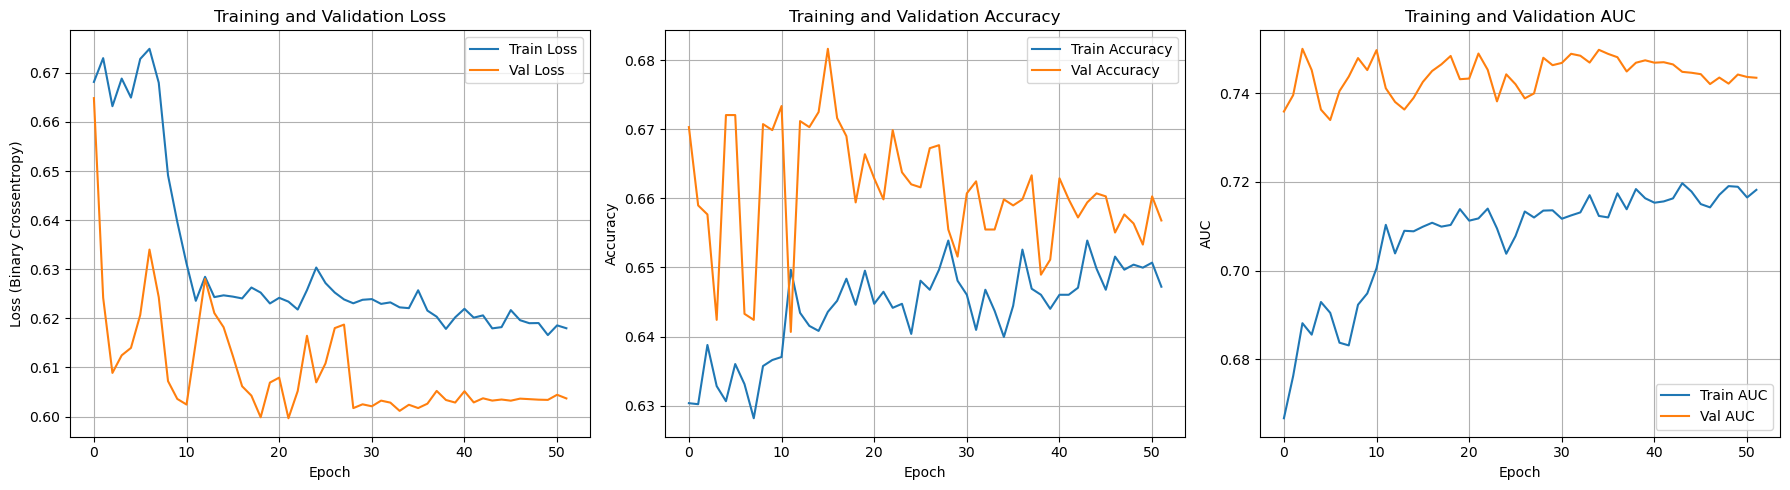

In [48]:
# ===== 7) 학습 곡선 시각화 =====
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (Binary Crossentropy)')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(history.history['accuracy'], label='Train Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

# AUC
axes[2].plot(history.history['auc'], label='Train AUC')
axes[2].plot(history.history['val_auc'], label='Val AUC')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('AUC')
axes[2].set_title('Training and Validation AUC')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [49]:
# ===== 8) 모델 평가 (Validation) =====
val_loss, val_acc, val_auc = classifier.evaluate(X_val_scaled, y_val, verbose=0)

print("===== Validation 세트 평가 결과 =====")
print(f"Loss: {val_loss:.4f}")
print(f"Accuracy: {val_acc:.4f}")
print(f"AUC: {val_auc:.4f}")

# 예측
pred_val = classifier.predict(X_val_scaled, verbose=0)
pred_val_binary = (pred_val > 0.5).astype(int).flatten()

print("\nClassification Report:")
print(classification_report(y_val, pred_val_binary, target_names=['Phishing', 'Legitimate']))

===== Validation 세트 평가 결과 =====
Loss: 0.5997
Accuracy: 0.6598
AUC: 0.7489

Classification Report:
              precision    recall  f1-score   support

    Phishing       0.67      0.63      0.65      1148
  Legitimate       0.65      0.69      0.67      1148

    accuracy                           0.66      2296
   macro avg       0.66      0.66      0.66      2296
weighted avg       0.66      0.66      0.66      2296


Classification Report:
              precision    recall  f1-score   support

    Phishing       0.67      0.63      0.65      1148
  Legitimate       0.65      0.69      0.67      1148

    accuracy                           0.66      2296
   macro avg       0.66      0.66      0.66      2296
weighted avg       0.66      0.66      0.66      2296



In [50]:
# ===== 9) 모델 평가 (Test) =====
test_loss, test_acc, test_auc = classifier.evaluate(X_test_scaled, y_test, verbose=0)

print("===== Test 세트 평가 결과 =====")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_acc:.4f}")
print(f"AUC: {test_auc:.4f}")

# 예측
pred_test = classifier.predict(X_test_scaled, verbose=0)
pred_test_binary = (pred_test > 0.5).astype(int).flatten()

print("\nClassification Report:")
print(classification_report(y_test, pred_test_binary, target_names=['Phishing', 'Legitimate']))

===== Test 세트 평가 결과 =====
Loss: 0.6007
Accuracy: 0.6504
AUC: 0.7430

Classification Report:
              precision    recall  f1-score   support

    Phishing       0.67      0.61      0.63      1148
  Legitimate       0.64      0.70      0.67      1149

    accuracy                           0.65      2297
   macro avg       0.65      0.65      0.65      2297
weighted avg       0.65      0.65      0.65      2297



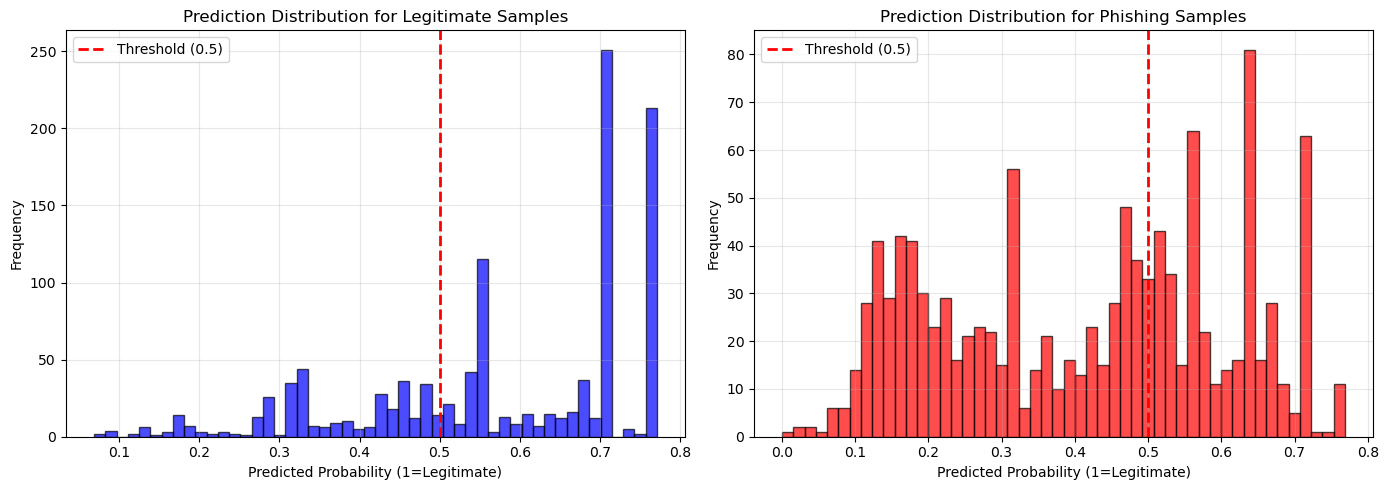


정상 사이트 평균 예측값: 0.5781
피싱 사이트 평균 예측값: 0.4125


In [51]:
# ===== 11) 예측 확률 분포 시각화 =====
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

legit_mask = (y_test == 1)
phish_mask = (y_test == 0)

# 정상 사이트의 예측 확률 분포
axes[0].hist(pred_test[legit_mask], bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold (0.5)')
axes[0].set_xlabel('Predicted Probability (1=Legitimate)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Prediction Distribution for Legitimate Samples')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 피싱 사이트의 예측 확률 분포
axes[1].hist(pred_test[phish_mask], bins=50, alpha=0.7, color='red', edgecolor='black')
axes[1].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold (0.5)')
axes[1].set_xlabel('Predicted Probability (1=Legitimate)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Prediction Distribution for Phishing Samples')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n정상 사이트 평균 예측값: {pred_test[legit_mask].mean():.4f}")
print(f"피싱 사이트 평균 예측값: {pred_test[phish_mask].mean():.4f}")

t-SNE 변환 중...


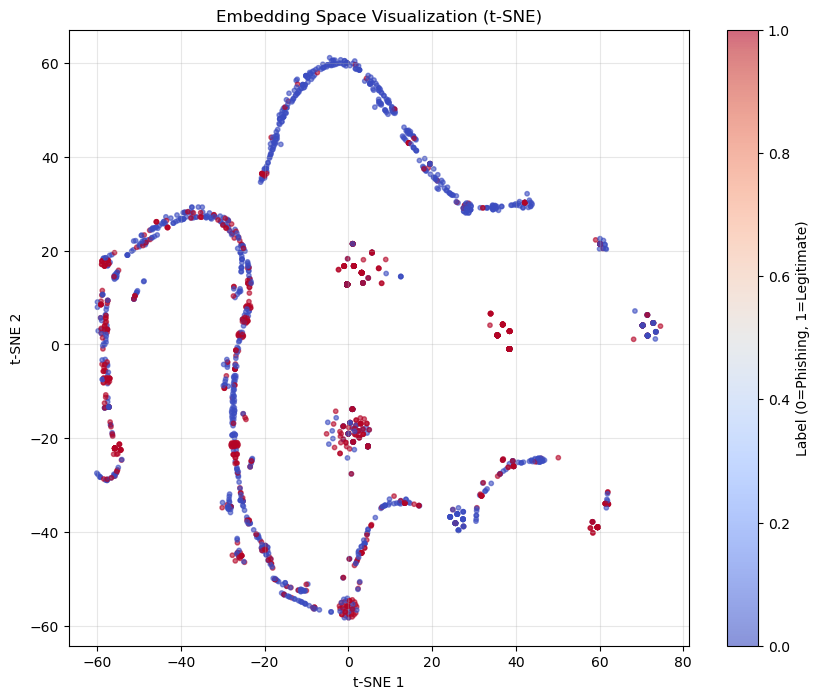

In [52]:
# ===== 12) 임베딩 공간 시각화 (t-SNE) =====
from sklearn.manifold import TSNE

# Encoder로 임베딩 추출
embeddings_test = encoder.predict(X_test_scaled, verbose=0)

# t-SNE 변환 (2D)
print("t-SNE 변환 중...")
tsne = TSNE(n_components=2, random_state=RANDOM_SEED, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings_test)

# 시각화
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                      c=y_test, cmap='coolwarm', alpha=0.6, s=10)
plt.colorbar(scatter, label='Label (0=Phishing, 1=Legitimate)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Embedding Space Visualization (t-SNE)')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# ===== 13) 모델 저장 및 TFLite 변환 =====
import os

# 모델 경로 설정
OUTPUT_DIR = "/Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing"
CLASSIFIER_PATH = os.path.join(OUTPUT_DIR, "dynamic_model.h5")
SAVED_MODEL_PATH = os.path.join(OUTPUT_DIR, "dynamic_saved_model")
TFLITE_PATH = os.path.join(OUTPUT_DIR, "phishing_dynamic.tflite")

# 1) Classifier 모델 H5로 저장
print(f"Classifier 모델 저장 중: {CLASSIFIER_PATH}")
classifier.save(CLASSIFIER_PATH)
print("H5 모델 저장 완료!")

# 2) SavedModel 형식으로 저장
print(f"SavedModel로 저장 중: {SAVED_MODEL_PATH}")
classifier.export(SAVED_MODEL_PATH)
print("SavedModel 저장 완료!")

# 3) SavedModel에서 TFLite로 변환
print("TFLite 변환 중...")
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_PATH)
tflite_model = converter.convert()

with open(TFLITE_PATH, 'wb') as f:
    f.write(tflite_model)

print(f"✅ TFLite 모델 저장 완료: {TFLITE_PATH}")
print(f"📦 모델 크기: {len(tflite_model) / 1024:.2f} KB")

# 4) TFLite 모델 검증
interpreter = tf.lite.Interpreter(model_path=TFLITE_PATH)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(f"\n입력 shape: {input_details[0]['shape']}")
print(f"출력 shape: {output_details[0]['shape']}")
print("✅ TFLite 모델 검증 완료!")

Classifier 모델 저장 중: /Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing/classifier_model.h5
H5 모델 저장 완료!
SavedModel로 저장 중: /Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing/classifier_saved_model
INFO:tensorflow:Assets written to: /Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing/classifier_saved_model/assets
INFO:tensorflow:Assets written to: /Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing/classifier_saved_model/assets


INFO:tensorflow:Assets written to: /Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing/classifier_saved_model/assets


Saved artifact at '/Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing/classifier_saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 79), dtype=tf.float32, name='encoder_input')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  4579341792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15727610688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15429169776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15429166256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15429164848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15429163088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15429161328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15429170832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15430354016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15430353312: TensorSpec(shape=(), dtype=tf.resource, name=N

W0000 00:00:1764063319.071884 2901197 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1764063319.071897 2901197 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
